In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sasmodels.core import load_model
from sasdata.dataloader.loader import Loader
from sasmodels.direct_model import call_kernel
from sasmodels.direct_model import DirectModel
import io
from sasdata.data_util.loader_exceptions import NoKnownLoaderException
from contextlib import suppress

In [163]:
DATA_DIR = '/Users/pozzolabadmin/Documents/codebase/hyak_results/micelles_omiecs/results_sph/'
SAVE_DIR = './fitted_model_info/'
logging_file = DATA_DIR+'logging_sph.out' 
with open(logging_file) as file:
    logged_output = [line.rstrip() for line in file]


In [164]:
# Following are most likely spherical micelles with a PHFBA core and PDEGEEA corona
FIT_KEYS = [116,118,129,125,127,132,134,135,136,138,139,140,931,932,933,964,965,970,971]
TESTING = False 
SLD_CORE = 1.85
SLD_CORONA = 0.817
SLD_SOLVENT_LIST = {'dTHF': 6.349, 'THF': 0.183, 'D2O':6.36, 
'H2O':-0.561, 'dCF': 3.156, 'dTol':5.664, 'dAcetone':5.389,
'dTHF0':6.360, 'dTHF25':6.357, 'dTHF50':6.355, 'dTHF75':6.352,'hTHF':1.0
}
SI = pd.read_csv('./sample_info_OMIECS.csv')

def load_data_from_file(fname, use_trim=False):
    flag = SI["Filename"]==fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load('./subtracted_incoherent/%s'%fname)[0]
    
    if not use_trim:
        data.qmin = min(data.x)
        data.qmax = max(data.x)
    else:
        data.qmin = data.x[metadata['lowq_trim']]
        data.qmax = data.x[-metadata['Highq_trim']]
        
    return data, metadata

In [165]:
def get_fitted_values(fname):
    lookup_line = "Final fitting parameters for :  %s"%fname
    for i, line in enumerate(logged_output):
        if lookup_line in line:
            print(line)
            scale = float(logged_output[i+2].split(' ')[-1].split('\n')[0])
            v_core = float(logged_output[i+3].split(' ')[-1].split('\n')[0])
            v_corona = float(logged_output[i+4].split(' ')[-1].split('\n')[0])
            radius_core = float(logged_output[i+5].split(' ')[-1].split('\n')[0])
            radius_core_pd = float(logged_output[i+6].split(' ')[-1].split('\n')[0])
            rg = float(logged_output[i+7].split(' ')[-1].split('\n')[0])
            d_penetration = float(logged_output[i+8].split(' ')[-1].split('\n')[0])
            background = 0.0 
        
            break 
    
    data, metadata = load_data_from_file(fname, use_trim=True)
    SLD_SOLVENT = SLD_SOLVENT_LIST[metadata.Solvent.values[0]]
    
    sphere_params = {'v_core' : v_core,
         'v_corona' : v_corona,
         'sld_solvent' : SLD_SOLVENT,
         'sld_core' : SLD_CORE,
         'sld_corona' : SLD_CORONA,
         'radius_core': radius_core,
         'rg': rg,
         'd_penetration':d_penetration,
         'n_aggreg' : 67.0,
         'radius_core_pd':radius_core_pd, 
         'radius_core_pd_n':23, 
         'radius_core_pd_nsigma':3,
         'scale':scale,
         'background':background
         }

    return data, metadata, sphere_params

In [166]:
def plot(fname):
    # Spherical micelle in sasmodels
    kernel = load_model("../models/spherical_micelle.py")
    data, metadata, sphere_params = get_fitted_values(fname)
    model = DirectModel(data, kernel)
    Iq_fitted = model(**sphere_params)

    units = ['Å^3','Å^3', '1e-6 Å^-2', '1e-6 Å^-2', '1e-6 Å^-2', 'Å', 'Å', '', '', '', '', '', '', '']
    col_1 = np.asarray(list(sphere_params.values()))
    col_2 = np.asarray(units)
    cellText = np.vstack((col_1, col_2)).T

    fig, axs = plt.subplots(1,3, figsize=(4*3, 4))
    axs[0].axis('off')
    axs[0].axis('tight')
    axs[0].table(cellText=cellText, rowLabels=list(sphere_params.keys()), 
            colLabels=['Value', 'Units'], loc='center')
    axs[0].set_title('Fitted values')
    axs[1].table(cellText=metadata.values.squeeze().reshape(19,1), 
                rowLabels=metadata.columns.values, 
                loc='center'
                )
    axs[1].axis('off')
    axs[1].axis('tight')
    axs[1].set_title('Sample information')
    ax = axs[2]
    ax.scatter(data.x, data.y, label='True')
    min_max_mask = (data.x >= data.qmin) & (data.x <= data.qmax)
    q_mask = data.x[min_max_mask]
    ax.axvline(x=data.qmin, color='k')
    ax.axvline(x=data.qmax, color='k')   
    ax.plot(q_mask, Iq_fitted, label='predicted', color='tab:orange')
    ax.set_xlabel('q')
    ax.set_ylabel('I(q)')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Fitted curve')
    fig.subplots_adjust(left=0.2, top=0.8, wspace=0.6)
    plt.savefig(SAVE_DIR + fname+'.png', dpi=600)

    return 


Final fitting parameters for :  D50F25b_10dTol.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F25b_10dTol.sub'


Final fitting parameters for :  D50F25_10dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F25_10dTHF75.sub'


Final fitting parameters for :  D50F25b_10dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F25b_10dTHF75.sub'


Final fitting parameters for :  D50F50_10dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F50_10dTHF75.sub'


Final fitting parameters for :  D50F50_10dTol.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F50_10dTol.sub'


Final fitting parameters for :  D50F75_10dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F75_10dTHF75.sub'


Final fitting parameters for :  D50F75_10dTol.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F75_10dTol.sub'


Final fitting parameters for :  D50F50_10dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F50_10dTHF50.sub'


Final fitting parameters for :  D50F75_10dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F75_10dTHF50.sub'


Final fitting parameters for :  P50F25_1dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F25_1dTHF50.sub'


Final fitting parameters for :  P50F25_10_dTHF25.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F25_10_dTHF25.sub'


Final fitting parameters for :  P50F25_10_dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F25_10_dTHF50.sub'


Final fitting parameters for :  P50F25_10_dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F25_10_dTHF75.sub'


Final fitting parameters for :  P50F25_5dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F25_5dTHF50.sub'


Final fitting parameters for :  P50F50_1dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F50_1dTHF50.sub'


Final fitting parameters for :  P50F50_10_dTHF25.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F50_10_dTHF25.sub'


Final fitting parameters for :  P50F50_10_dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F50_10_dTHF50.sub'


Final fitting parameters for :  P50F50_10_dTHF75.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F50_10_dTHF75.sub'


Final fitting parameters for :  P50F50_5dTHF50.sub


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/P50F50_5dTHF50.sub'


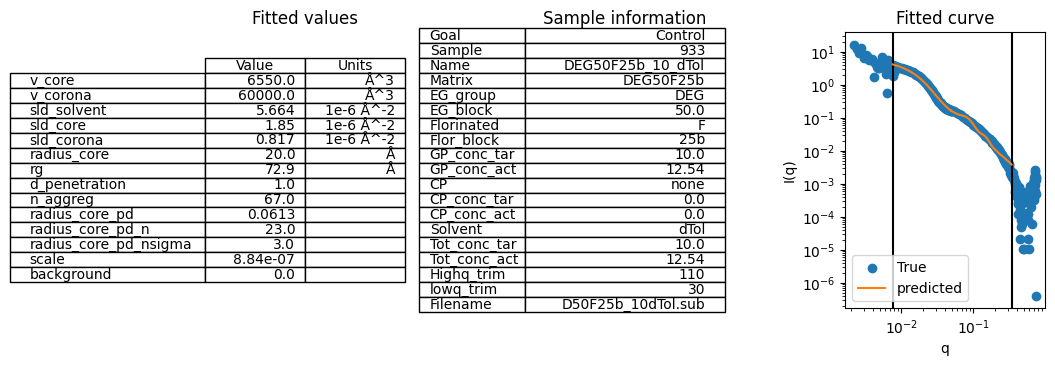

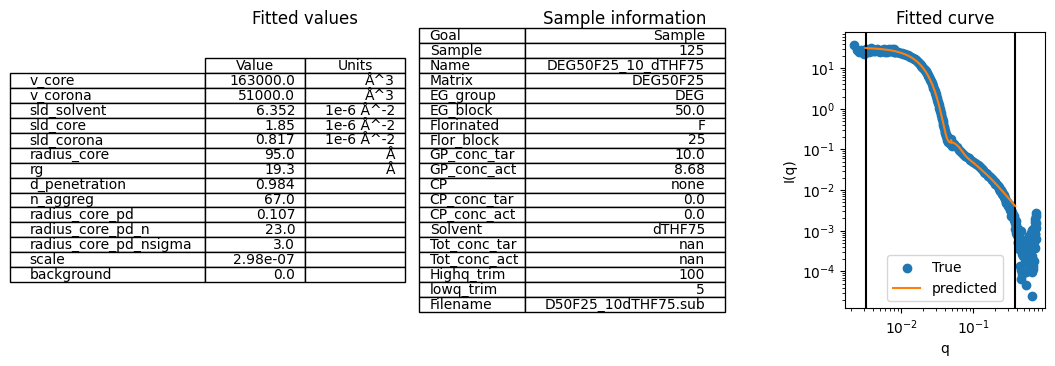

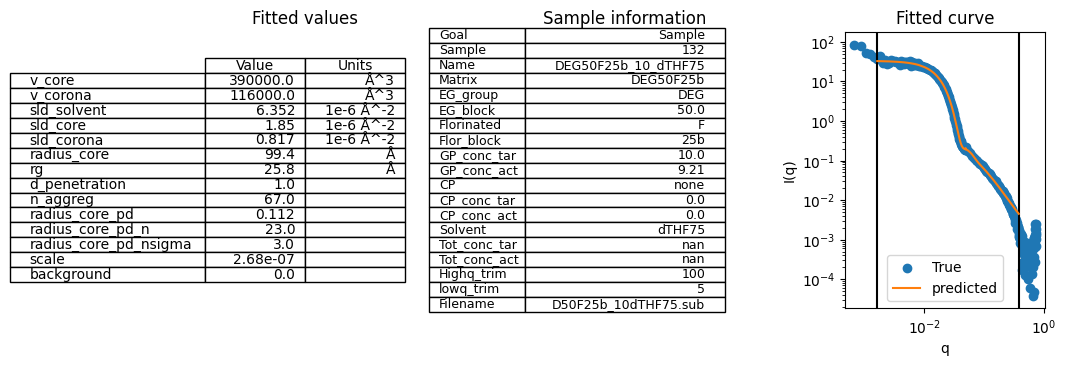

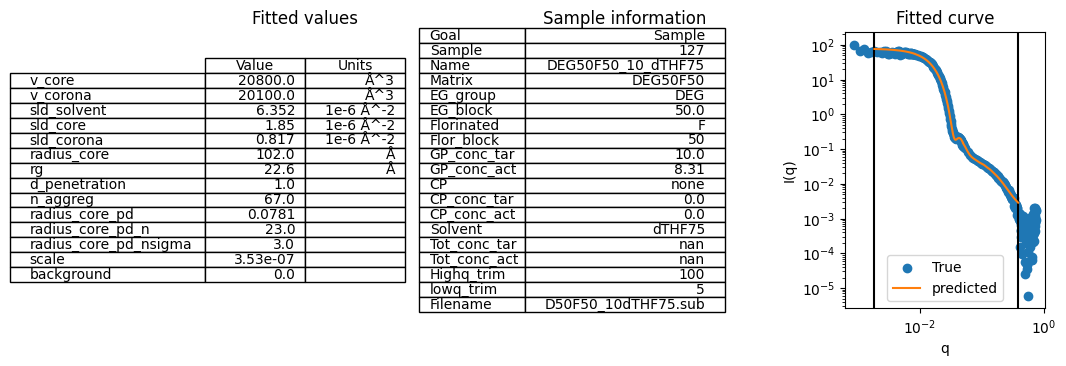

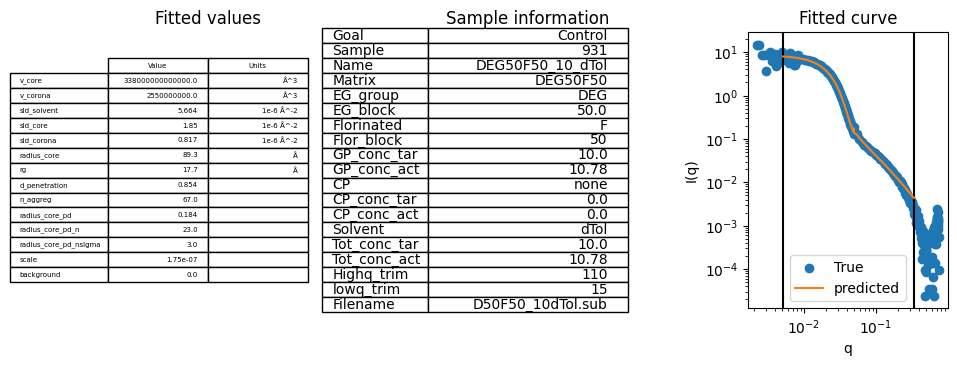

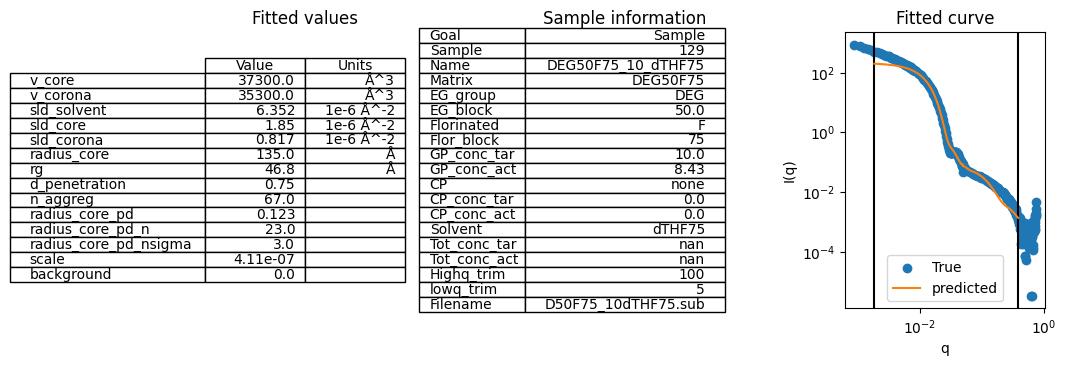

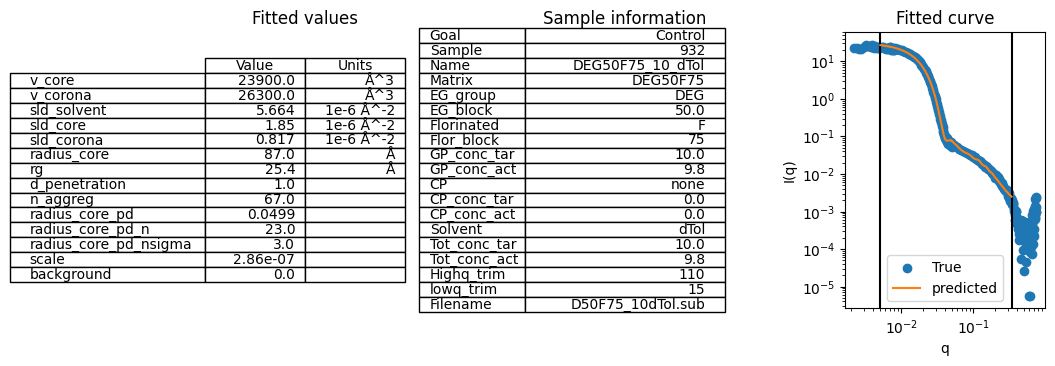

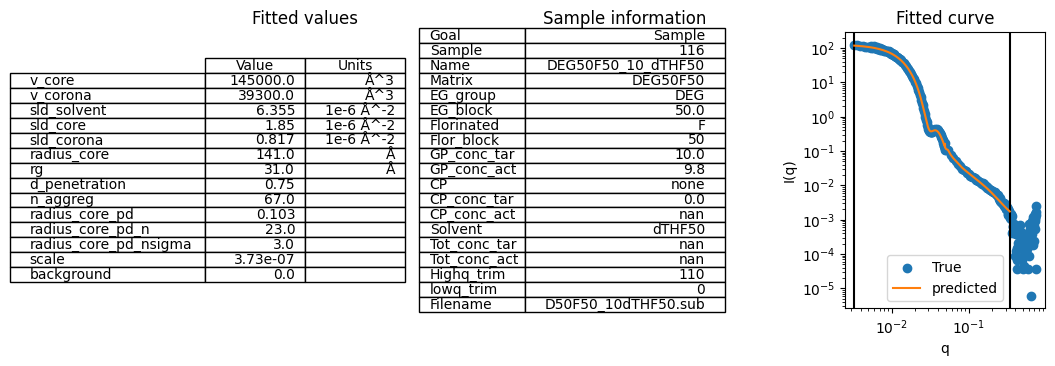

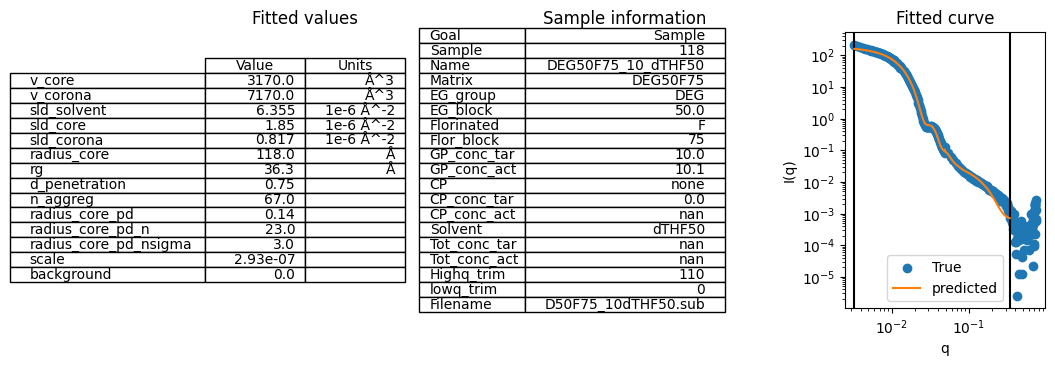

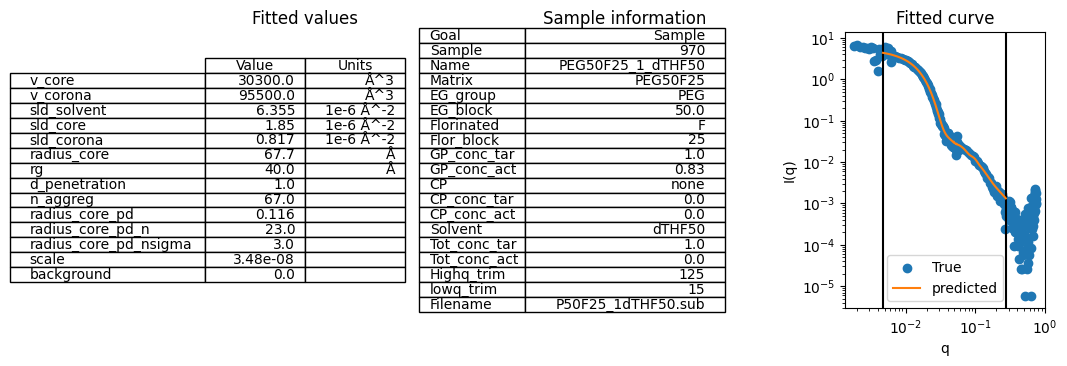

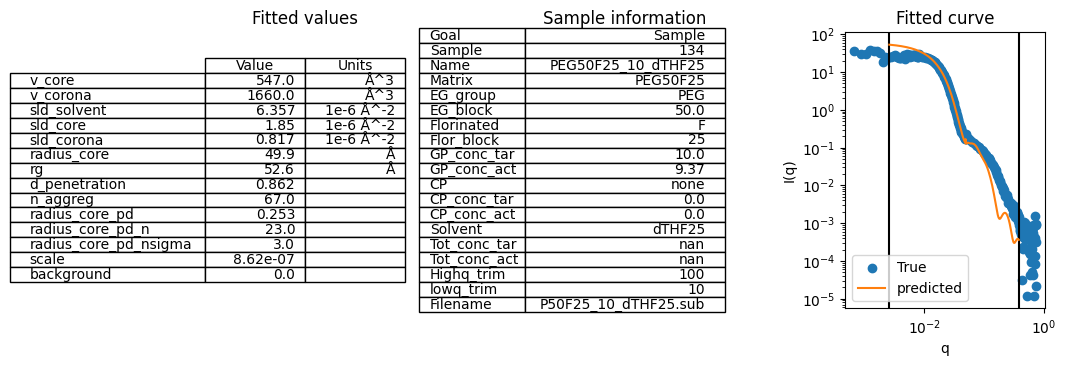

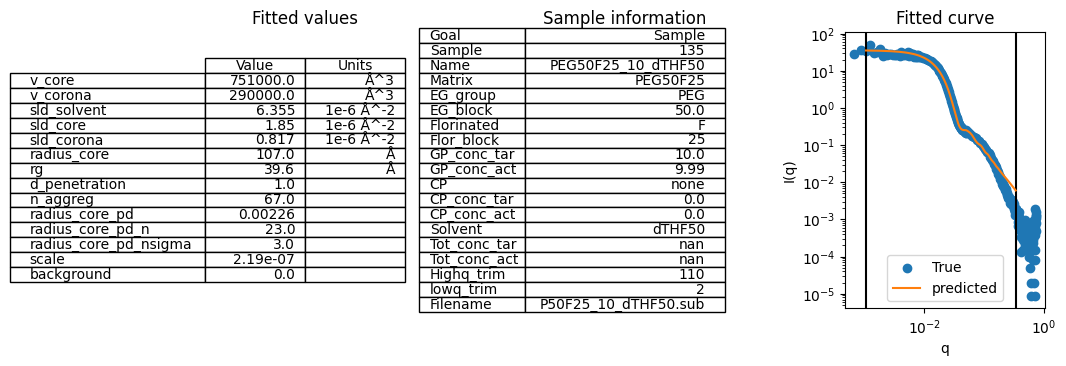

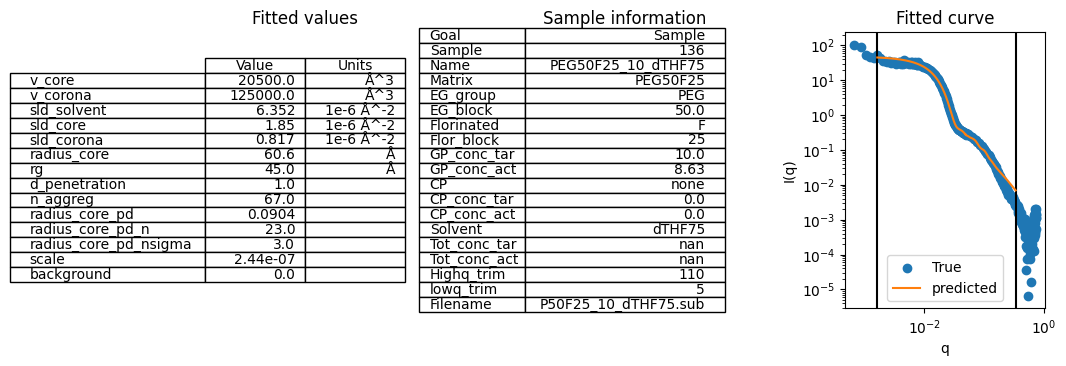

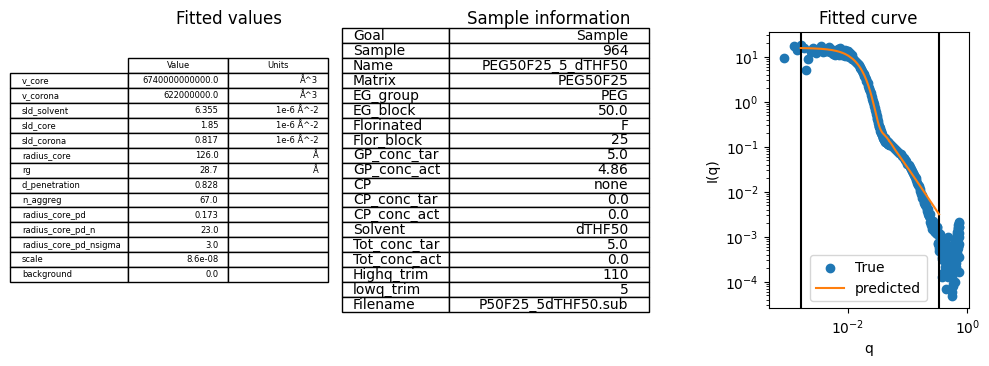

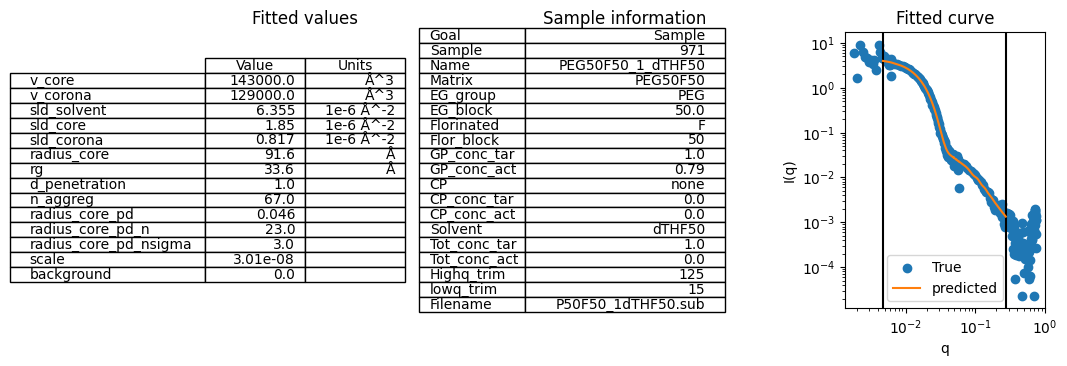

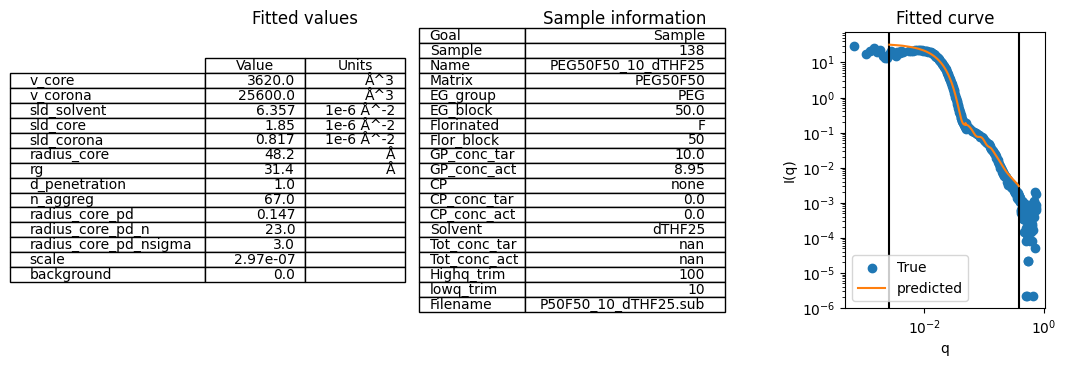

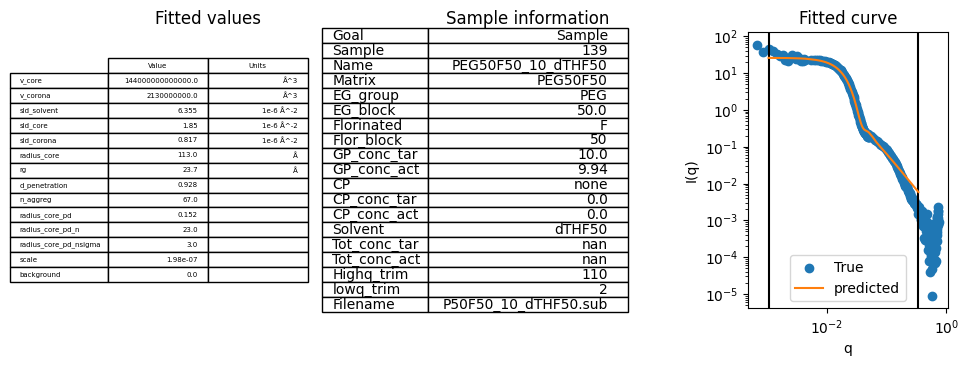

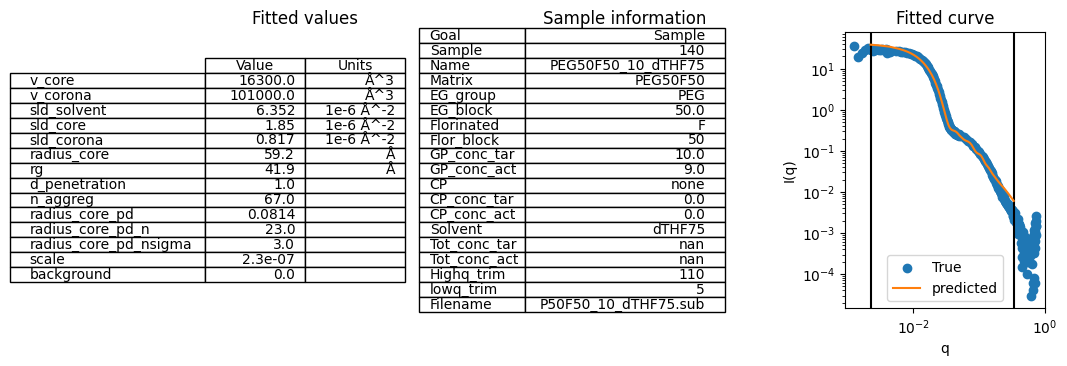

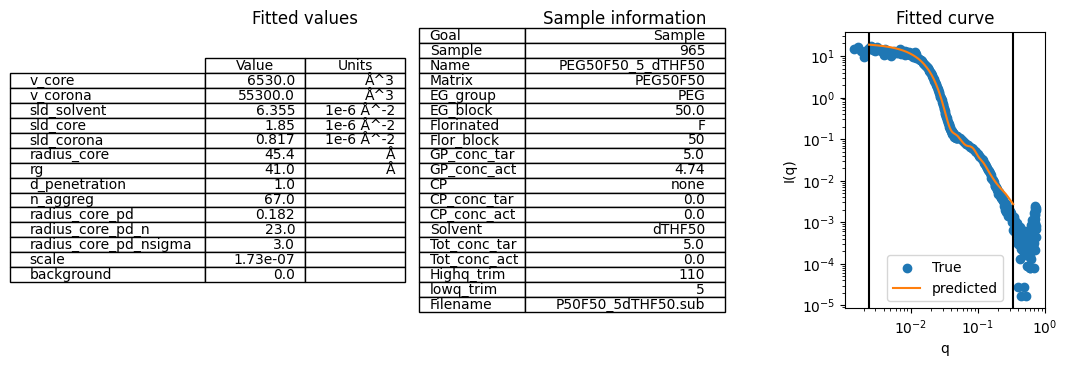

In [167]:
for key, values in SI.iterrows():
    if values['Sample'] in FIT_KEYS:
        fname = values['Filename']
        plot(fname)